# Quickstart

![pytdgl logo](https://raw.githubusercontent.com/loganbvh/py-tdgl/main/docs/images/logo-transparent-small.png)

`pyTDGL` solves a generalized time-depdendent Ginzburg-Landau (TDGL) equation for two-dimensional superconducting device with arbitrary geometry. At a high level, the TDGL model can be understood as a set of coupled partial differential equations (PDEs) describing the evolution of a complex field $\psi(\mathbf{r}, t)$ (the superconducting order parameter) and $\mu(\mathbf{r}, t)$ (the electric potential) in space and time.

The inputs to the model are:

1. Properties of the superconducting thin film: thickness $d$, Ginzburg-Landau coherence length $\xi$, and London penetration depth $\lambda$ (see `tdgl.Layer`).
2. The geometry of the device residing in the film, which can include holes (see `tdgl.Polygon`).
3. A time-independent applied magnetic vector potential $\mathbf{A}_\mathrm{applied}(\mathbf{r})$.
4. A set of applied bias currents which are sourced or sunk via a set of current terminals.

The outputs of the model are:

1. The complex order parameter $\psi(\mathbf{r}, t)=|\psi|e^{i\theta}$, where $|\psi|^2=n_s$ is the normalized superfluid density.
2. The electric scalar potential $\mu(\mathbf{r}, t)$, which arises from motion of vortices in the film.
3. The sheet current density in the device, $\mathbf{K}(\mathbf{r}, t)=\mathbf{K}_s(\mathbf{r}, t)+\mathbf{K}_n(\mathbf{r}, t)$, which is the sum of the sheet supercurrent density $\mathbf{K}_s$ and the sheet normal current density $\mathbf{K}_n$.

While the TDGL calculation is performed in dimensionless units, the inputs and outputs are specified in experimentalist-friendly physics units. The translation between the two is handled by the `tdgl.Device` class.

In [36]:
%config InlineBackend.figure_formats = {"retina", "png"}

import os
import tempfile

os.environ["OPENBLAS_NUM_THREADS"] = "1"

from IPython.display import HTML, display
import h5py
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["figure.figsize"] = (5, 4)

import tdgl
from tdgl.geometry import box, circle
from tdgl.visualization.animate import create_animation

Optionally, generate and display animations of the simulated dynamics.

In [37]:
MAKE_ANIMATIONS = True

We will save the data to a temporary directory that will be removed at the end of the notebook.

In [38]:
tempdir = tempfile.TemporaryDirectory()

Below we can create animations of the time-dependent simulation results. This is a helper function that animates a `tdgl.Solution` object so that it can be embedded in a notebook.

In [39]:
def make_video_from_solution(
    solution,
    quantities=("order_parameter", "phase"),
    fps=20,
    figsize=(5, 4),
):
    """Generates an HTML5 video from a tdgl.Solution."""
    with tdgl.non_gui_backend():
        with h5py.File(solution.path, "r") as h5file:
            anim = create_animation(
                h5file,
                quantities=quantities,
                fps=fps,
                figure_kwargs=dict(figsize=figsize),
            )
            video = anim.to_html5_video()
        return HTML(video)

## Superconducting weak link

In this notebook, we model a mesoscopic superconducting device with one circular hole, one square hole, and a weak link.

### Defining the device

The geometry of a `tdgl.Device` is defined using a collection of `tdgl.Polygon` objects. A `Polygon` is defined by an array `points`, which specifies the `(x, y)` coordinates of the polygon vertices. Simple geometeries (rectangles and ellipses) can be generated using `box()`, `ellipse()`, and `circle()` from the `tdgl.geometry` module. Polygons with more complex geometries can be generated through affine transformations (scaling, rotation, etc.) and [constructive solid geometry](https://en.wikipedia.org/wiki/Constructive_solid_geometry) operations (union, difference, intersection). There should be a single `tdgl.Polygon` defining the outer geometry of the superconducting `film`, and zero or more `Polygons` defining holes in that film.

If you would like to apply a transport current through one or more terminals in the device, you must specify a set of `terminals`. Any points in the device that lie within a given terminal and are on the boundary of the mesh will have the appropriate transport current boundary conditions imposed. You may also specify two or more positions in the device (called `probe_points`) for which the scalar potential $\mu$ and the phase $\theta$ will be evaluated as a function of time.

In [40]:
length_units = "um"
# Material parameters
xi = 0.5
london_lambda = 2
d = 0.1
layer = tdgl.Layer(coherence_length=xi, london_lambda=london_lambda, thickness=d, gamma=1)

# Device geometry
total_width = 5
total_length = 3.5 * total_width
link_width = total_width / 3
# Outer geometry of the film
right_notch = (
    tdgl.Polygon(points=box(total_width))
    .rotate(45)
    .translate(dx=(np.sqrt(2) * total_width + link_width) / 2)
)
left_notch = right_notch.scale(xfact=-1)
film = (
    tdgl.Polygon("film", points=box(total_width, total_length))
    .difference(right_notch, left_notch)
    .resample(401)
    .buffer(0)
)
# Holes in the film
round_hole = (
    tdgl.Polygon("round_hole", points=circle(link_width / 2))
    .translate(dy=total_length / 5)
)
square_hole = (
    tdgl.Polygon("square_hole", points=box(link_width))
    .rotate(45)
    .translate(dy=-total_length / 5)
)
# Current terminals
source = (
    tdgl.Polygon("source", points=box(1.1 * total_width, total_length / 100))
    .translate(dy=total_length / 2)
)
drain = source.scale(yfact=-1).set_name("drain")
#  Voltage measurement points
probe_points = [(0, total_length / 2.5), (0, -total_length / 2.5)]

In [41]:
device = tdgl.Device(
    "weak_link",
    layer=layer,
    film=film,
    holes=[round_hole, square_hole],
    terminals=[source, drain],
    probe_points=probe_points,
    length_units=length_units,
)

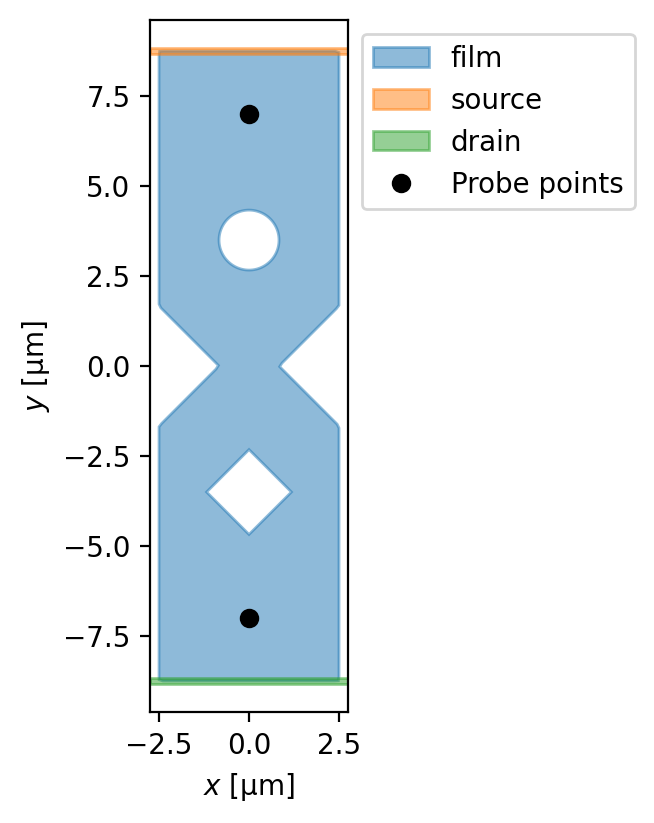

In [42]:
fig, ax = device.draw()

Generate the finite volume mesh by calling `tdgl.Device.make_mesh()`. You can specify a minimum number of mesh vertices (`min_points`) and/or a maximum edge length (`max_edge_length`). Generally, the edges in the mesh should be small compared to the coherence length $\xi$.

In [43]:
device.make_mesh(max_edge_length=xi / 2, smooth=100)

Constructing Voronoi polygons: 100%|██████████| 4647/4647 [00:01<00:00, 2493.11it/s]


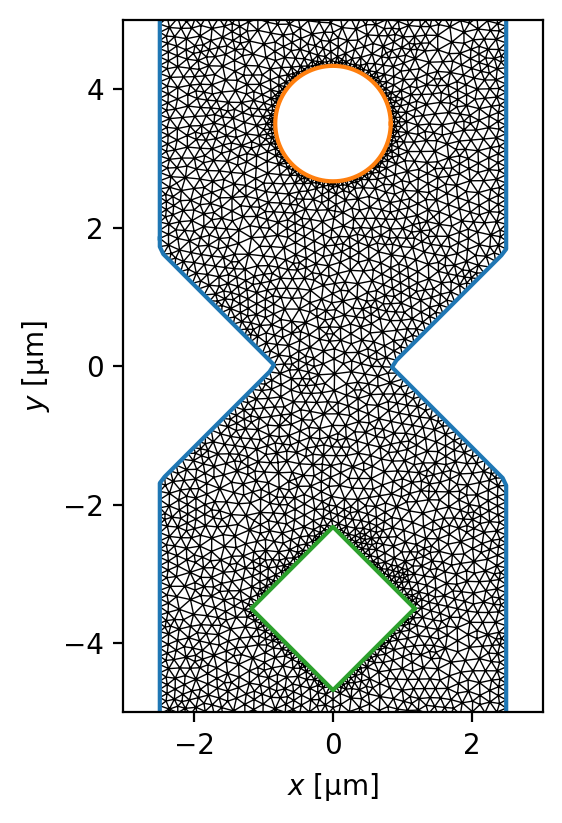

In [44]:
fig, ax = device.plot(mesh=True, legend=False)
_ = ax.set_ylim(-5, 5)

In [45]:
device.mesh_stats()

num_sites,4647
num_elements,8700
min_edge_length,3.696e-02
max_edge_length,2.452e-01
mean_edge_length,1.409e-01
min_area,8.108e-04
max_area,3.934e-02
mean_area,1.657e-02
coherence_length,5.000e-01
length_units,um


### Simulating with zero applied field

Below we simulate our device with zero applied magnetic field and a constant bias current flowing from the source terminal (top) to the drain terminal (bottom).

The behavior of the TDGL solver is specified by creating an instance of `tdgl.SolverOptions`. If the `output_file` parameter is not given, the results of the simulation will not be saved, and only the results from the final solve step will be accessible in the resulting `tdgl.Solution`. The `save_every` parameter determines how often the results are saved to disk, e.g., `save_every = 100` means that the outputs $\psi(\mathbf{r}, t)$, $\mu(\mathbf{r}, t)$, $\mathbf{K}_s(\mathbf{r}, t)$, and $\mathbf{K}_n(\mathbf{r}, t)$ will be saved every 100 solve steps. The scalar potential and phase at the two `probe_points` will be saved for every time step, regardless of the value of `save_every`.

Executing a TDGL simulation is accomplished by calling `tdgl.solve()`. `tdgl.solve()` returns a `tdgl.Solution` instance, which can be used to post-process, inspect, and visualize the results of the simulation.

In [46]:
options = tdgl.SolverOptions(
    # Allow some time to equilibrate before saving data.
    skip_time=100,
    solve_time=150,
    output_file=os.path.join(tempdir.name, "weak-link-zero-field.h5"),
    field_units = "mT",
    current_units="uA",
    save_every=100,
)
# If you do not provide an applied_vector_potential, tdgl defaults to zero applied field.
zero_field_solution = tdgl.solve(
    device,
    options,
    # terminal_currents must satisfy current conservation, i.e.,
    # sum(terminal_currents.values()) == 0.
    terminal_currents=dict(source=12, drain=-12),
)

Simulating: 100%|█████████▉| 150/150 [00:28<00:00,  5.30tau/s ]


Here we plot the sheet current density $\mathbf{K}(\mathbf{r})$ at the final time step, and measure the total current flowing from top to bottom. The dashed orange line indicates the curve through which the total current is calculated.

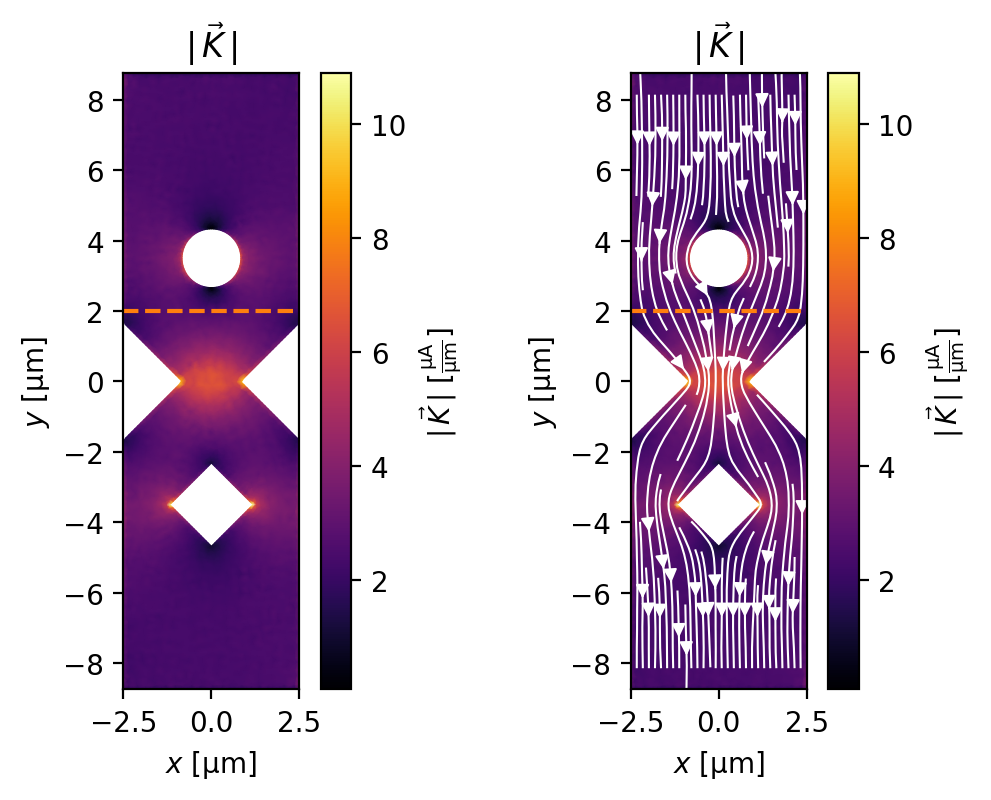

In [47]:
fig, axes = plt.subplots(1, 2, figsize=(6, 4))

_ = zero_field_solution.plot_currents(ax=axes[0], streamplot=False)
_ = zero_field_solution.plot_currents(ax=axes[1])
# Define the coordinates at which to evaluate the sheet current density
x = np.linspace(-total_width / 2, total_width / 2, 401)
y = 2 * np.ones_like(x)
cross_section = np.array([x, y]).T
for ax in axes:
    _ = ax.plot(x, y, "C1--")

In [24]:
current = zero_field_solution.current_through_path(cross_section)
print(f"Measured current: {current:.3f~P}")

Measured current: 11.930 µA


When there is zero applied magnetic field and an applied bias current $I_\mathrm{bias}$ that exceeds the critial current of the weak link, the weak link acts as a site for vortex or phase slip nucleation driven by the bias current.

Due to the symmetry of the device and the absence of an applied field, vortices are formed in vortex-antivortex (V-aV) pairs: a vortex is nucleated on the right side of the link and an antivortex is nucleated on the left side of the link. The vortex and antivortex are pushed together by the attractive force between the two and by the Lorentz force from the bias current, so they each move towards the center of the link and eventually annihilate one another. The creation and annihilation of a single V-aV pair in the weak link causes the phase between the top and bottom halves of the device to advance by $2\pi$, and causes a spike in the voltage between the top and bottom halves.

In the figure below, a vortex-antivortex pair is clearly visible in the weak link.

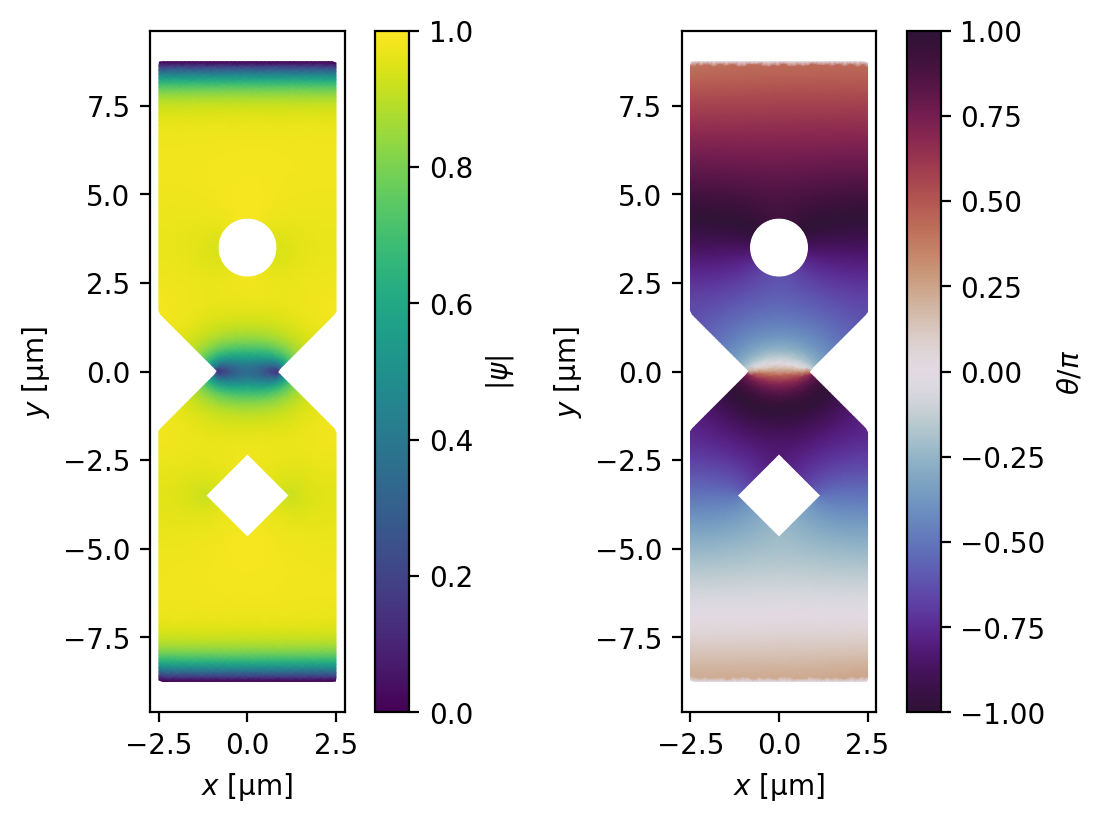

In [25]:
# Plot a snapshot of the order parameter in the middle of a phase slip
t0 = 112
zero_field_solution.solve_step = zero_field_solution.closest_solve_step(t0)
fig, axes = zero_field_solution.plot_order_parameter(figsize=(5.5, 4))

Below we plot the dynamics of the voltage and phase between the top and bottom halves of the device. The dashed horizontal line indicates the time-averaged voltage and the vertical gray line corresponds to the snapshot above. `tdgl.Solution.dynamics` is a container for the voltage and phase difference between the two `probe_points`, which are measured at each time step.

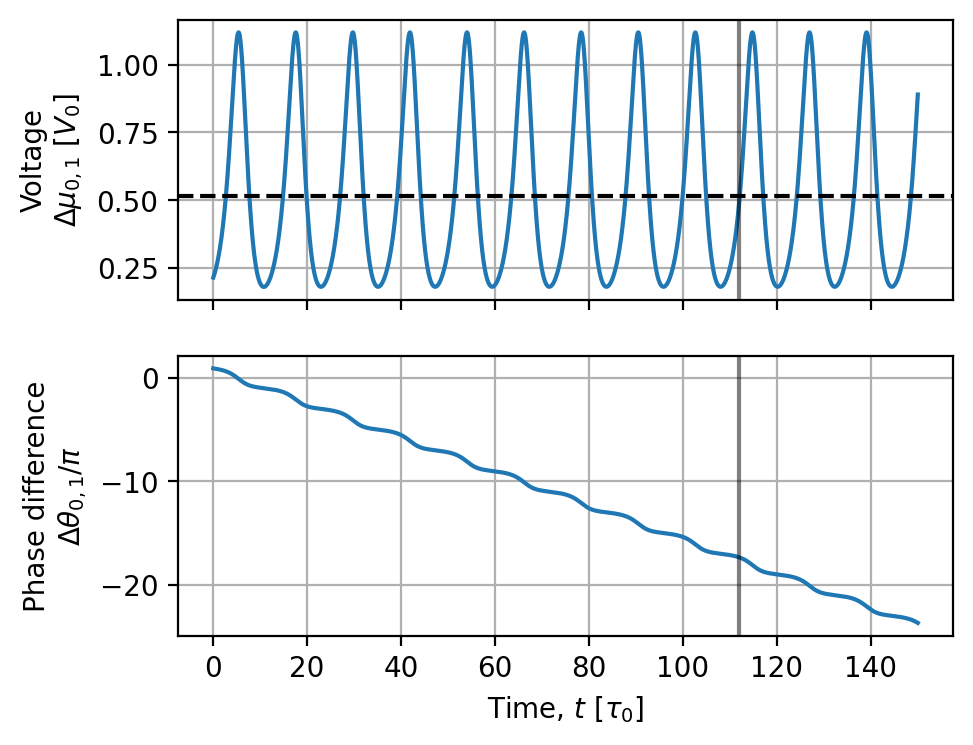

In [26]:
fig, axes = zero_field_solution.dynamics.plot()
for ax in axes:
    ax.axvline(t0, color="k", alpha=0.5)

If we zoom in on a short slice of time, we can see that each voltage spike is associated with a $2\pi$ phase slip:

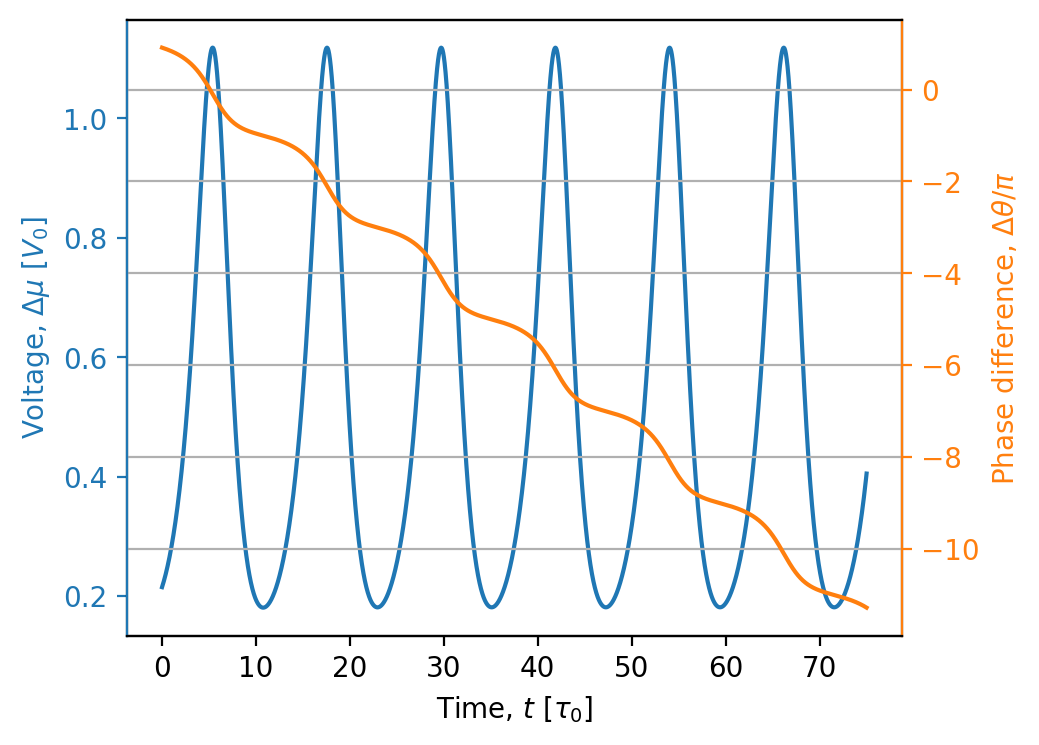

In [27]:
dynamics = zero_field_solution.dynamics
indices = dynamics.time_slice(tmax=75)

fig, ax = plt.subplots()
# Plot the voltage on the left y axis
ax.plot(dynamics.time[indices], dynamics.voltage()[indices], "C0-")
ax.tick_params(axis="y", color="C0", labelcolor="C0")
ax.set_ylabel("Voltage, $\\Delta\\mu$ [$V_0$]", color="C0")
ax.set_xlabel("Time, $t$ [$\\tau_0$]")

# Plot the phase difference on the right y axis
bx = ax.twinx()
unwrapped_phase = np.unwrap(dynamics.phase_difference()[indices])
bx.plot(dynamics.time[indices], unwrapped_phase / np.pi, "C1")
bx.grid(axis="both")
bx.spines["right"].set_color("C1")
bx.spines["left"].set_color("C0")
bx.tick_params(axis="y", color="C1", labelcolor="C1")
_ = bx.set_ylabel("Phase difference, $\\Delta\\theta/\\pi$", color="C1")

We can visualize the simulated dynamics as a function of position in the device by creating an animation. Note that because `tdgl` uses an adaptive time step by default, each frame of the animation does not correspond to the same amount of time. If you would like to create an animation with a constant frame rate, you should set `tdgl.SolverOptions.adaptive = False` to force a constant time step.

**Animation**: Zero applied field, $\mu_0H_z=0\,\mathrm{mT}$, $I_\mathrm{bias}=12\,\mu\mathrm{A}$

In [28]:
if MAKE_ANIMATIONS:
    zero_field_video = make_video_from_solution(
        zero_field_solution,
        quantities=["order_parameter", "phase", "scalar_potential"],
        figsize=(6.5, 4),
    )
    display(zero_field_video)

RuntimeError: Requested MovieWriter (ffmpeg) not available

### Simulating vortex dynamics with zero bias current

When there is zero bias current and an applied out-of-plane magnetic field $\mu_0H_z$ that exceeds the lower critical field of the device, vortices enter the film and either become trapped in one of the holes or remain in the film. The final position of the vortices is determined by the applied field and the repulsive vortex-vortex interaction.

In [29]:
options = tdgl.SolverOptions(
    solve_time=200,
    output_file=os.path.join(tempdir.name, "weak-link-zero-current.h5"),
    field_units = "mT",
    current_units="uA",
)

RAMP_FIELD = True

if RAMP_FIELD:
    from tdgl.sources import LinearRamp, ConstantField

    # Ramp the applied field from 0 to 0.4 mT between t=0 and t=100, then hold it at 0.4 mT.
    applied_vector_potential = (
        LinearRamp(tmin=0, tmax=100)
        * ConstantField(0.4, field_units=options.field_units, length_units=device.length_units)
    )
else:
    # If applied_vector_potential is given as a single number,
    # it is interpreted to mean the vector potential associated with a
    # uniform out-of-plane magnetic field with the specified strength.
    # This is simply shorthand for
    # ConstantField(0.4, field_units=options.field_units, length_units=device.length_units).
    applied_vector_potential = 0.4

zero_current_solution = tdgl.solve(
    device,
    options,
    applied_vector_potential=applied_vector_potential,
)

Simulating: 100%|█████████▉| 200/200 [01:26<00:00,  2.31tau/s ]


The total number of vortices that have entered the film can be found by looking at the number of white contours (corresponding to phase $\arg\psi=0$) in the plot of the phase of the order parameter below. We see that two vortices have been trapped in each of the two holes, and there are two vortices sitting in the film.

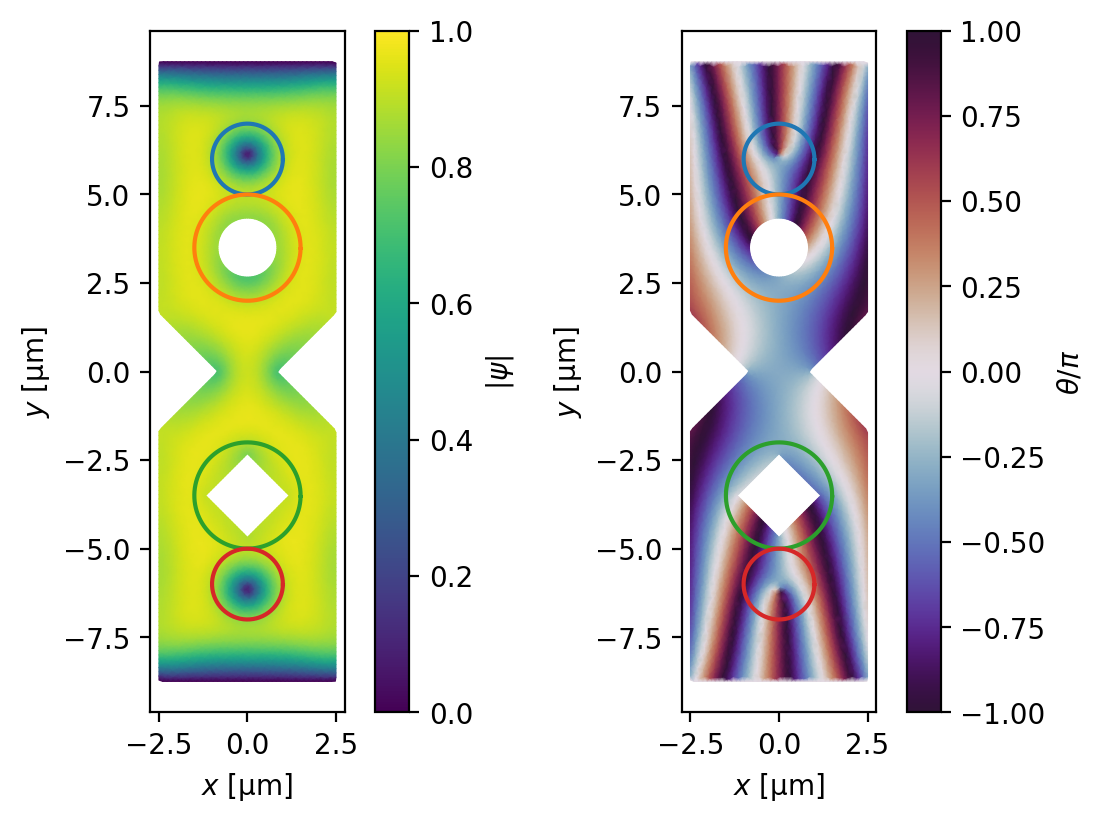

In [30]:
fig, axes = zero_current_solution.plot_order_parameter(figsize=(5.5, 4))

fluxoid_polygons = {
    # name: (circle radius, circle center)
    "Top vortex": (1, (0, 6)),
    "Round hole": (1.5, (0, 3.5)),
    "Square hole": (1.5, (0, -3.5)),
    "Bottom vortex": (1, (0, -6)),
}
for name, (radius, center) in fluxoid_polygons.items():
    polygon = circle(radius, center=center, points=201)
    for ax in axes:
        ax.plot(*polygon.T)

We can verify that the two vortices in the film each contain a single flux quantum by evaluating the fluxoid for a curve surrounding each vortex. The fluxoid for a closed curve $C$ is given by

$$
\begin{split}
\Phi_C &= \Phi_C^\mathrm{flux} + \Phi_C^\mathrm{supercurrent}\\
&= \oint_C\mathbf{A}(\mathbf{r})\cdot\mathrm{d}\mathbf{r}
    +\oint_C\mu_0\Lambda(\mathbf{r})\mathbf{K}_s(\mathbf{r})\cdot\mathrm{d}\mathbf{r}\\
&=\frac{\Phi_0}{2\pi}\oint_C\nabla\theta(\mathbf{r})\cdot\mathrm{d}\mathbf{r},
\end{split}
$$

where $\mathbf{K}_s$ is the sheet supercurrent density, $\Lambda(\mathbf{r})=\Lambda_0/|\psi(\mathbf{r})|^2$ is the effective magnetic penetration depth, $\Lambda_0=\lambda_0^2/d$ is the zero-field effective magnetic penetration depth, and $\theta(\mathbf{r})$ is the unwrapped phase of the order parameter. The method `tdgl.Solution.polygon_fluxoid()` evaluates the fluxoid for a given curve using the second line of the equation above, i.e. by evalulating the magnetic flux through the region enclosed by the curve and the line integral of the supercurrent density around the curve.

In [31]:
for name, (radius, center) in fluxoid_polygons.items():
    polygon = circle(radius, center=center, points=201)
    fluxoid = zero_current_solution.polygon_fluxoid(polygon, with_units=False)
    print(
        f"{name}:\n\t{fluxoid} Phi_0\n\tTotal fluxoid: {sum(fluxoid):.2f} Phi_0\n"
    )

Top vortex:
	Fluxoid(flux_part=0.6064915910732913, supercurrent_part=0.40852878960194394) Phi_0
	Total fluxoid: 1.02 Phi_0

Round hole:
	Fluxoid(flux_part=1.3656431774811417, supercurrent_part=0.6186360587268066) Phi_0
	Total fluxoid: 1.98 Phi_0

Square hole:
	Fluxoid(flux_part=1.3652203791001294, supercurrent_part=0.6258885550824383) Phi_0
	Total fluxoid: 1.99 Phi_0

Bottom vortex:
	Fluxoid(flux_part=0.6065317336584155, supercurrent_part=0.41255222429791577) Phi_0
	Total fluxoid: 1.02 Phi_0



We can also calculate the fluxoid for each hole by measuring the number of $2\pi$ phase windings around the hole (i.e., the third line of the equation above). The method `tdgl.Solution.boundary_phases()` returns the phase of the order parameter at each boundary site in the mesh. Our device has three boundaries: the outer boundary of the film, plus the inner boundary of the two holes.

In [32]:
boundary_phases = zero_current_solution.boundary_phases()
for hole in device.holes:
    phases = boundary_phases[hole.name].phases
    fluxoid_from_phase = (phases[-1] - phases[0]) / (2 * np.pi)
    print(f"Total fluxoid for {hole.name!r}: {fluxoid_from_phase:.2f} Phi_0")

Total fluxoid for 'round_hole': 1.98 Phi_0
Total fluxoid for 'square_hole': 1.99 Phi_0


Note that we cannot use this method to find the total fluxoid of the film because the outer boundary includes the two current terminals, along which $\psi=0$ and therefore the phase $\arg\psi$ is not well defined.

Finally, we can also plot the supercurrent density flowing in the device.

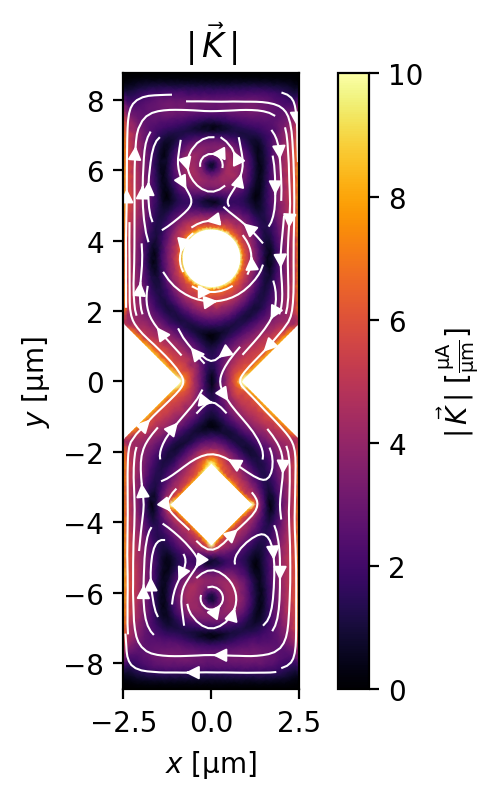

In [33]:
fig, ax = zero_current_solution.plot_currents(min_stream_amp=0.075, vmin=0, vmax=10)

**Animation**: Zero bias current, $\mu_0H_z=0.4\,\mathrm{mT}$, $I_\mathrm{bias}=0\,\mu\mathrm{A}$

In [ ]:
if MAKE_ANIMATIONS:
    zero_current_video = make_video_from_solution(zero_current_solution)
    display(zero_current_video)

### Simulating dynamics with applied field and current

Next, we model the dynamics of the device when it is subject to *both* an applied magnetic field and an applied bias current. Below we "seed" the model with the results from `zero_current_solution`, our previous simulation in which the bias current was zero. In this way we can model the scenario where a magnetic field is applied and then at a later time a bias current is applied.

In [ ]:
options = tdgl.SolverOptions(
    solve_time=200,
    output_file=os.path.join(tempdir.name, "weak-link.h5"),
    field_units="mT",
    current_units="uA",
)

field_current_solution = tdgl.solve(
    device,
    options,
    applied_vector_potential=0.4,
    terminal_currents=dict(source=12, drain=-12),
    # The seed solution will be used as the initial state of the film.
    seed_solution=zero_current_solution,
)

Simulating: 100%|████████████████████████████████████████████████████████████████████████████████████████▉| 200/200 [00:42<00:00,  4.73tau/s ]


The dynamics of the voltage across the device are now significantly more complex than they were when we had a bias current with no applied field.

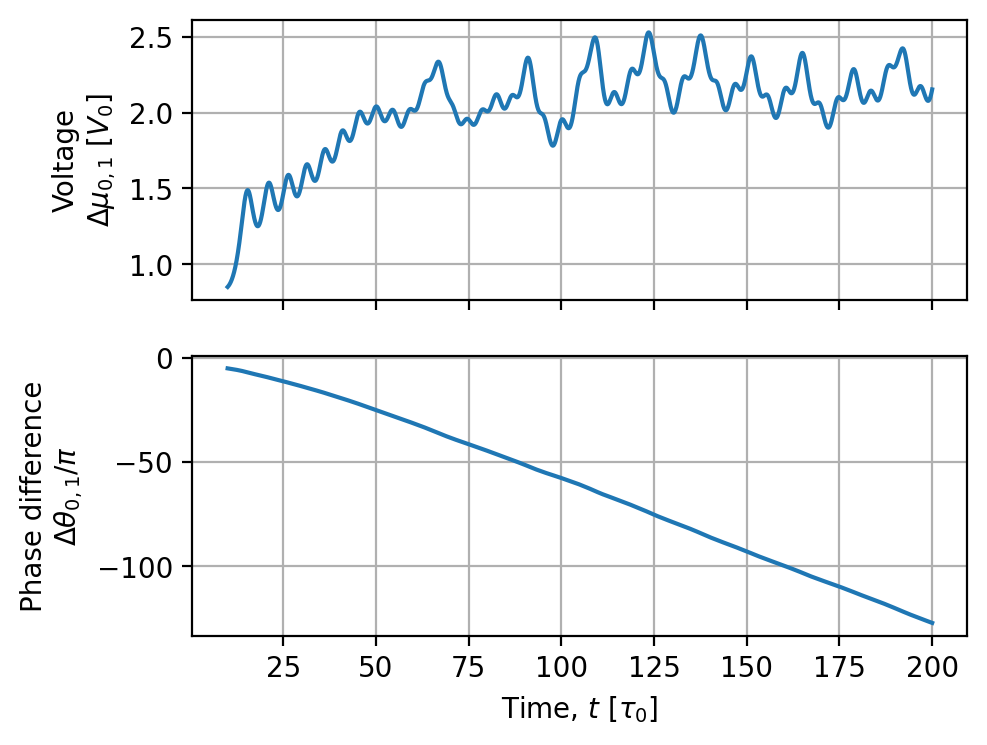

In [ ]:
fig, axes = field_current_solution.dynamics.plot(tmin=10, mean_voltage=False)

Vortices are pushed from right to left by the Lorentz force from the bias current and the voltage across the device is determined by the rate at which vortices cross from right to left. As can be seen in the animation below, vortices can cross the device in one of three general ways:

1. Directly across the weak link
2. Directly across the wide leads of the device
3. Across the leads, getting temporarily trapped in one of the holes

**Animation**: Applied field and current, $\mu_0H_z=0.4\,\mathrm{mT}$, $I_\mathrm{bias}=12\,\mu\mathrm{A}$

In [ ]:
if MAKE_ANIMATIONS:
    field_current_video = make_video_from_solution(
        field_current_solution,
        quantities=["order_parameter", "phase", "scalar_potential"],
        figsize=(6.5, 4),
    )
    display(field_current_video)

In [34]:
tempdir.cleanup()

In [35]:
tdgl.version_table()

Software,Version
tdgl,0.8.3
Numpy,1.26.4
SciPy,1.10.1
matplotlib,3.9.1
cupy,None
numba,0.60.0
IPython,8.26.0
Python,"3.10.14 | packaged by Anaconda, Inc. | (main, May 6 2024, 19:44:50) [MSC v.1916 64 bit (AMD64)]"
OS,nt [win32]
Number of CPUs,"Physical: 16, Logical: 16"
